# Clustering


In [1]:
# Graphic option. You may need it to show inline plots...
#import plotly.io as pio
#pio.renderers.default='notebook'

# Opción para python 3.12 [gráficos de plotly en notebook]
import plotly.offline as pyo
import plotly.graph_objs as go

# Set notebook mode to work in offline
pyo.init_notebook_mode()

# Introducción

En esta documento exploramos los métodos clásicos de clustering en sus variantes jerárquica y no jerárquica y una posible implementación de los mismos en Python que incluye ajuste de modelo, elección del número óptimo de grupos y evaluación de la solución de agrupación propuesta. 
En la primera sección haremos un ejercicio de simulación de datos que ilustra en dos dimensiones el funcionamiento de los algoritmos y su potencia de clasificación a pesar de tener una naturaleza no supervisada. 


In [2]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (12,10)

# Preprocesado y modelado
# ==============================================================================
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn.metrics import silhouette_score,silhouette_samples

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')


# Probando algortimos de clustering con datos simulados

La idea es que vamos a generar un dataset artificial con 2 variables y 300 registros con 4 centros (potenciales centroides a reconocer) y en el que podemos jugar a variar la variabilidad interna de los grupos de tal forma que cuanto mayor sea, el solapamiento en el plano de los puntos de cada grupo será mayor y, por tanto, más dificultad tendrá el problema de separar las clases.

Generamos entonces un matriz 2-dimensional **X** de variables y una variable de agrupación **y** que contiene la verdad verdadera (recordemos que esto no suele pasar en la vida real puesto que si tenemos la verdad nos inclinaremos por un modelo de clasificación supervisada!) y que servirá para comprobar la capacidad de clasificación de los métodos de clustering como si de un problema de clasificación supervisada se tratara. 

La subyacente pregunta es: Siendo estos métodos no supervisados, ¿serán capaces de reconocer grupos reales ya predefinidos?


In [3]:
plt.rcParams["figure.figsize"] = (12,10)
# Simulación de datos
# ==============================================================================
X, y = make_blobs(
        n_samples    = 300, # n observaciones
        n_features   = 2, # n variables
        centers      = 4, # n centros o grupos a generar
        cluster_std  = 0.8, # variabilidad de los grupos
        shuffle      = True, 
        random_state = 0
       )
X, y


(array([[ 0.43071995,  2.54925795],
        [-1.4687922 ,  7.26767764],
        [ 1.21486062,  5.36489604],
        [-0.94206983,  7.80806619],
        [ 1.01004604,  2.2241682 ],
        [ 3.89840088,  0.049651  ],
        [-1.90199536,  1.15672923],
        [ 1.55954253,  4.40697366],
        [ 0.14284237,  8.63097553],
        [-0.53204756,  8.93543127],
        [-1.77419557,  2.73110893],
        [-3.1439253 ,  8.52670186],
        [ 1.33136066,  4.57072679],
        [-2.5543634 ,  6.58124584],
        [ 1.25509524, -0.33815322],
        [ 0.27963236,  3.8407076 ],
        [ 1.10022802,  4.60631734],
        [ 2.74073201,  0.37684319],
        [-0.91357347,  3.20291652],
        [-0.92915335,  1.9667263 ],
        [ 2.9349952 ,  1.42187464],
        [ 1.68439074,  1.28284884],
        [ 0.65372852,  5.28174338],
        [-2.15300734,  2.82957082],
        [-2.04873889,  2.50093081],
        [-1.06612177,  4.8266822 ],
        [ 1.57821629,  0.85560982],
        [ 0.46759322,  4.844

Aquí tenemos la variable y de verdad verdadera con el grupo real al que pertenece cada observación de la matriz X. Utilizaremos para contrastar la clasificación propuesta por los métodos de clustering. 

Observamos el dataset en el espacio de dos dimensiones para valorar la nube de puntos y su solapamiento entre grupos como indicador de dificultad para el método de reconocimiento de grupos.


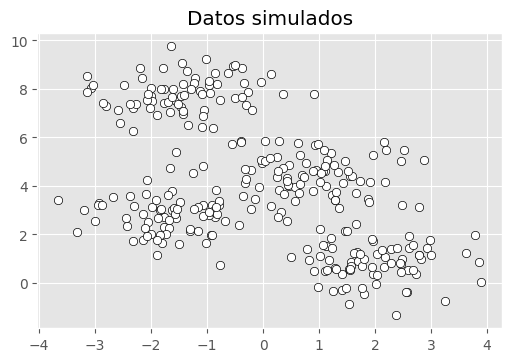

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.scatter(
    x = X[:, 0],
    y = X[:, 1], 
    c = 'white',
    marker    = 'o',
    edgecolor = 'black', 
)
ax.set_title('Datos simulados');
plt.show()


Se han formado 4 grupos con bastante separabilidad en el plano con lo que se intuye buen funcionamiento de los métodos de agrupación de instancias. La idea es contrastar los criterios de evaluación en el ambiente no supervisado (wss, silueta, %variabilidad..) con los criterios de evaluación bajo una verdad verdadera con matrices de confusión. De esta forma, podemos evaluar si la mejora en los primeros implica mejora en los segundos. 

En primer luegar, antes de la aplicación de métodos de clustering es conveniente escalar los datos si no podemos asegurar que la escala de medida sea la misma ya que distintas medidas afectan a la evaluación de distancias en el espacio haciendo que unas variables puedan "pesar" más que otras en la solución de forma "ilícita". 


In [5]:
# Escalado de datos
# ==============================================================================
X_scaled = scale(X)


Exploraremos los métodos de clustering jerárquicos y Kmeans y compararemos resultados.


## Clustering Jerárquico

Los métodos de clustering jerárquico servirán para hacerse una idea de la dinámica de agrupación de los datos y proponer, en base al dendograma, un número de grupos tentativos que presenten características comunes. 

Vamos a definir una función que facilite la creación del dendograma dado el modelo jerárquico que se desee visualizar. 


In [6]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from time import time


def plot_dendogram(model, **kwargs):
  
  '''
  Esta función extrae la información de un modelo AgglomerativeClustering
  y representa su dendograma con la función dendogram de scipy.cluster.hierarchy
  '''
      
  counts = np.zeros(model.children_.shape[0])
  n_samples = len(model.labels_)
  for i, merge in enumerate(model.children_):
    current_count = 0
    for child_idx in merge:
      if child_idx < n_samples:
        current_count += 1  # leaf node
      else:
        current_count += counts[child_idx - n_samples]
    counts[i] = current_count
  
  linkage_matrix = np.column_stack([model.children_, model.distances_,
                                        counts]).astype(float)
  
  # Plot
  dendrogram(linkage_matrix, **kwargs)
  plt.show()
    


**Distintos Linkages**

Aplicamos el dendograma para los 4 métodos de Linkage principales para comparar la dinámica de agrupación propuesta por cada uno de ellos. 


ward :	0.01s


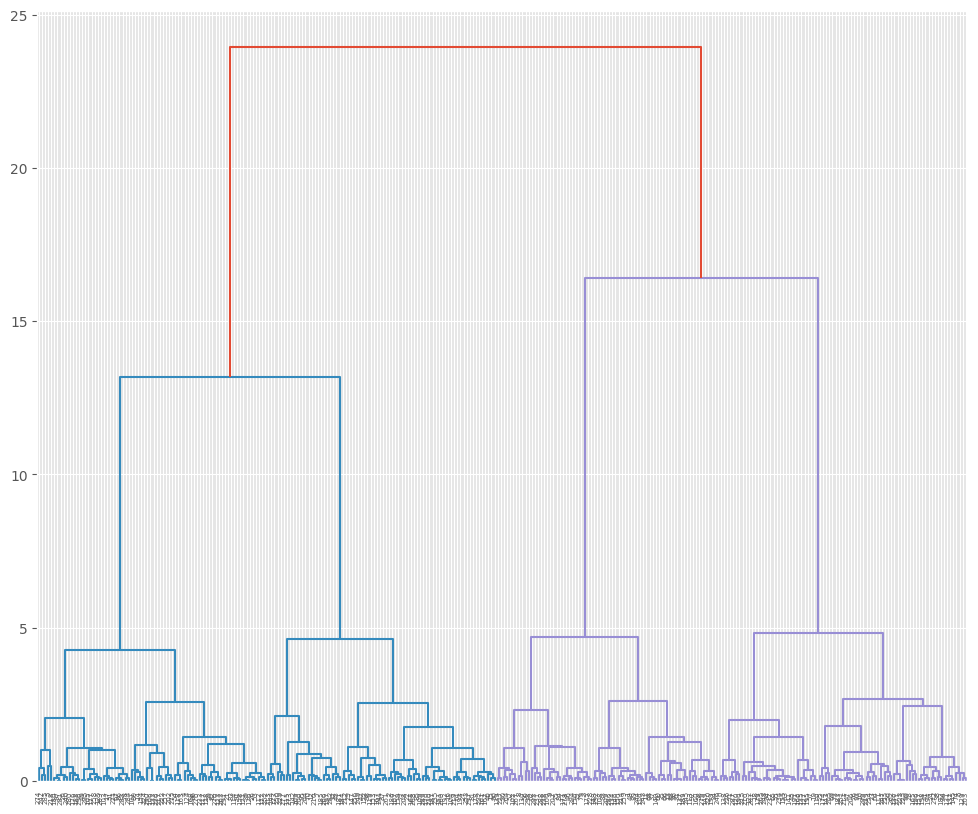

average :	0.00s


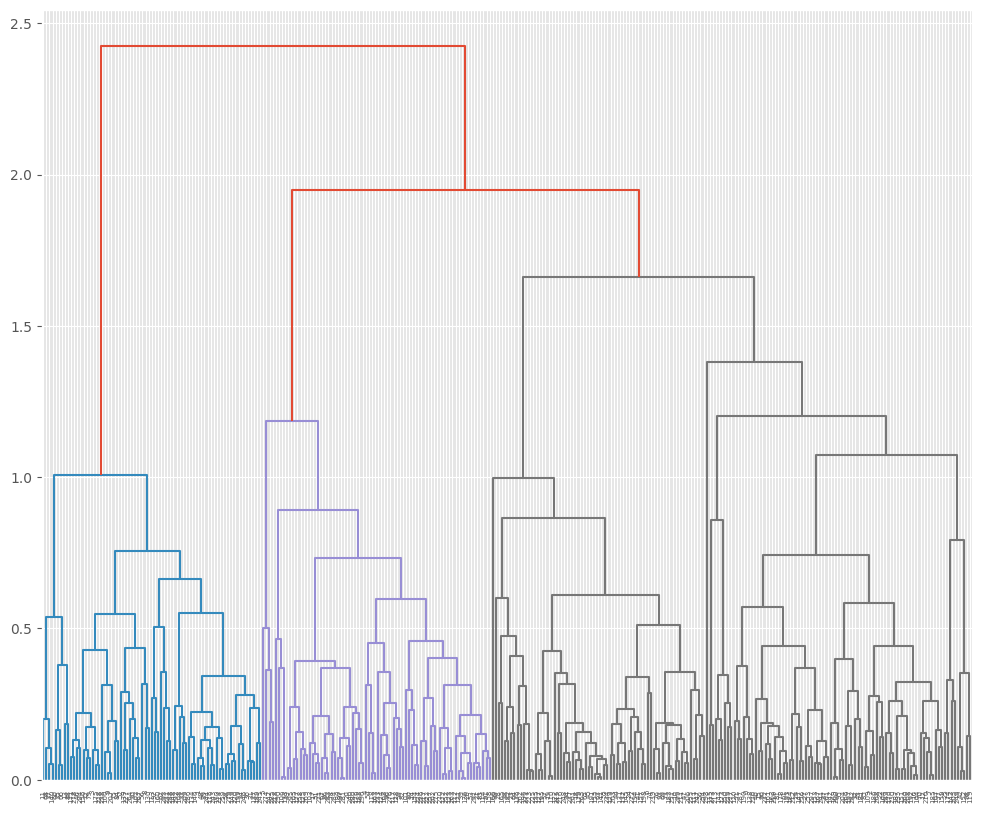

complete :	0.01s


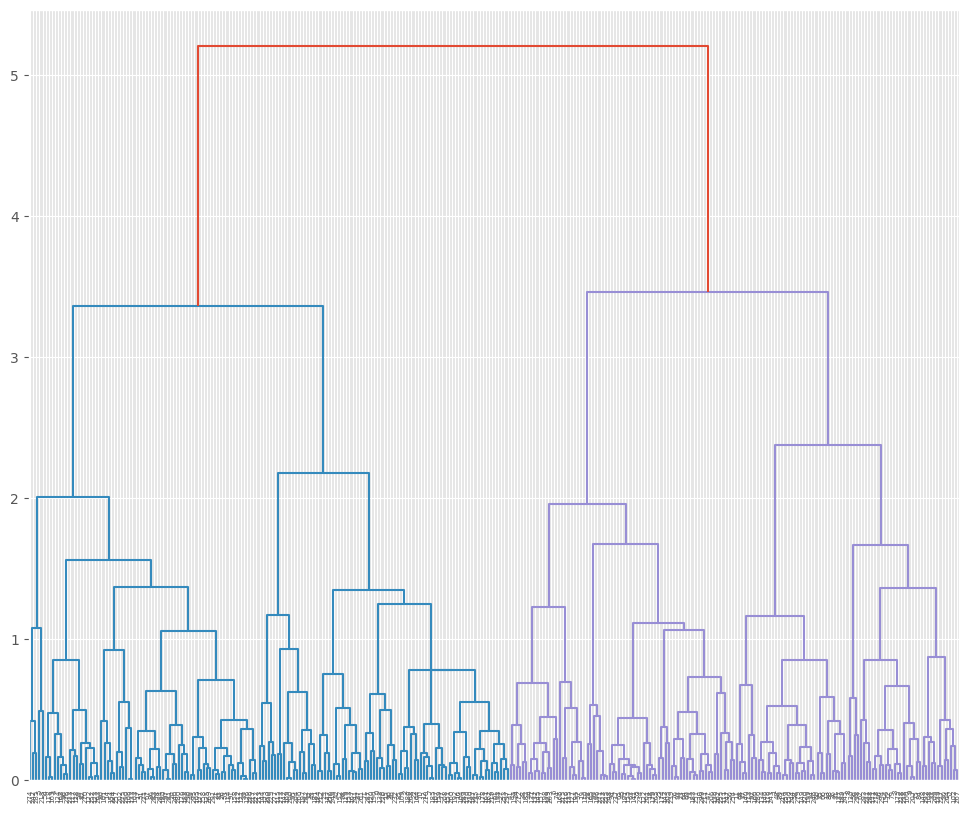

single :	0.00s


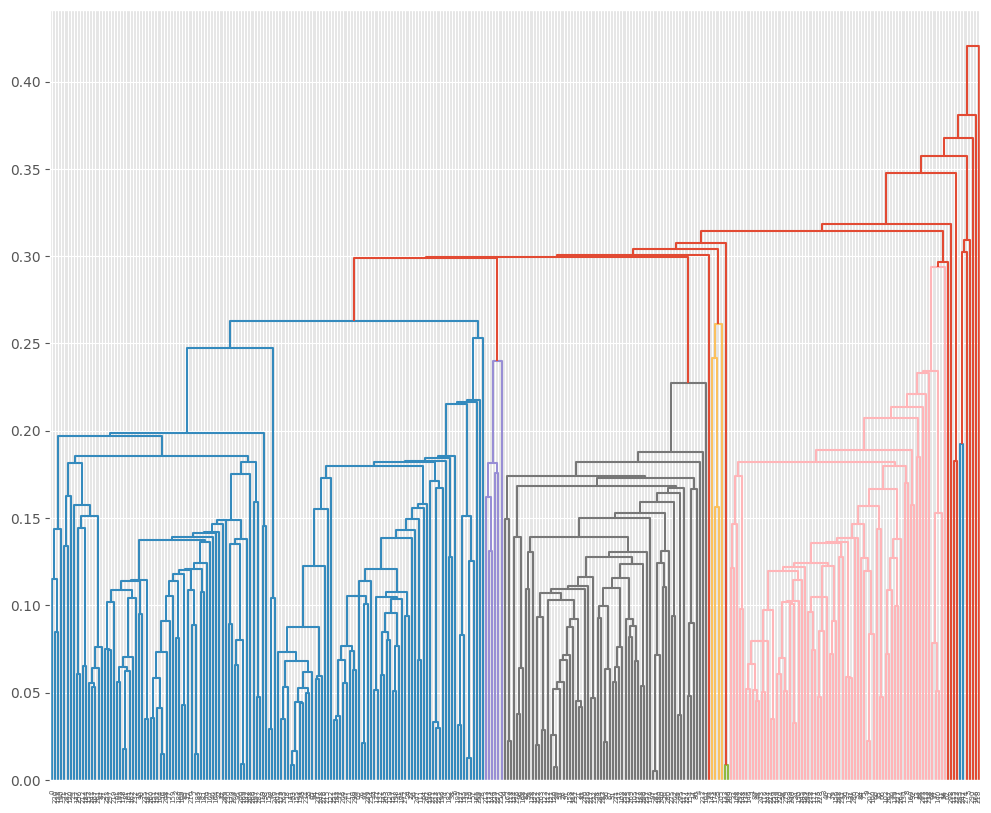

In [7]:
for linkage in ("ward", "average", "complete", "single"):
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=None,
                            distance_threshold = 0)
    t0 = time()
    clustering.fit(X_scaled)
    print("%s :\t%.2fs" % (linkage, time() - t0))
    
    plt.clf()
    plot_dendogram(clustering)
    #plot_clustering(X_scaled, clustering.labels_, "%s linkage" % linkage)


#plt.show()


### Modelo jerárquico escogido y número de clusters

Decidimos quedarnos con el método de mínima varianza de Ward ya que las alturas de corte parecen discriminar algo mejor a los grupos. Claramente se proponen 4 grupos (como no podía ser de otra manera ya que hay 4 grupos claramente). Vamos bien! 

Ajustamos un clustering jerárquico por el Linkage de Ward y 4 grupos. Extraeremos la clasificación propuesta en forma de vector de clase predicha y calcularemos dos métricas de evaluación en ambiente no supervisado: 

1. **Silueta**. El coeficiente de silueta se define para cada registro como $\frac{b-a}{max(a,b)}$ siendo **a** la distancia a su centroide y **b** la distancia al centroide del grupo más cercano y al que no pertenece dicho registro según la agrupación propuesta. Nos informa para cada registro de lo "bien" clasificado que se encuentra en su grupo actual o si tal vez estaría mejor perteneciendo al grupo más cercano. La función *silhouette_score* devuelve el promedio para todas las observaciones del archivo. Siempre se puede querer consultar los coeficientes para cada observación, lo haríamos con *silhouette_samples*.

2. **Indice de Calinski-Harabasz**. El criterio de la varianza de toda la vida. Compara la varianza entre grupos bss con la varianza intra wss a través de un cociente. Cuanto mayor sea el índice, mejor se considera el clustering. Fórmulación matemática concreta utilizada por la función de Python https://scikit-learn.org/stable/modules/clustering.html#calinski-harabasz-index


In [8]:
modelo_hclust_ward = AgglomerativeClustering(
                            metric = 'euclidean',
                            linkage  = 'ward',
                            n_clusters  = 4
                     )
modelo_hclust_ward.fit(X=X_scaled)

cluster_labels = modelo_hclust_ward.fit_predict(X_scaled)


In [9]:
cluster_labels

array([0, 2, 1, 2, 3, 3, 0, 1, 2, 2, 0, 2, 1, 2, 3, 1, 1, 3, 0, 0, 3, 3,
       1, 0, 0, 0, 3, 1, 0, 1, 2, 2, 1, 2, 2, 2, 2, 2, 0, 3, 1, 0, 1, 1,
       0, 0, 2, 0, 2, 3, 0, 3, 2, 3, 3, 0, 2, 0, 2, 3, 2, 1, 2, 0, 0, 0,
       2, 3, 2, 0, 1, 0, 2, 0, 0, 2, 0, 1, 3, 2, 3, 1, 3, 3, 2, 1, 3, 1,
       2, 2, 1, 3, 2, 0, 0, 1, 3, 3, 1, 0, 2, 3, 2, 3, 1, 3, 3, 1, 2, 1,
       0, 0, 3, 2, 3, 1, 2, 3, 3, 1, 0, 3, 0, 3, 3, 3, 3, 0, 3, 0, 2, 0,
       0, 3, 2, 0, 0, 2, 0, 2, 2, 0, 1, 0, 1, 0, 2, 1, 2, 2, 2, 1, 1, 1,
       3, 0, 2, 0, 3, 1, 2, 1, 1, 3, 1, 0, 0, 1, 3, 1, 1, 2, 3, 1, 0, 2,
       3, 3, 1, 0, 3, 1, 0, 0, 1, 1, 1, 1, 3, 2, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 2, 1, 0, 3, 0, 1, 0, 0, 2, 1, 2, 1, 0, 1, 1, 2, 0, 0, 3, 3, 1,
       2, 3, 3, 0, 3, 0, 0, 2, 2, 1, 1, 2, 1, 3, 0, 1, 3, 0, 2, 0, 3, 1,
       3, 2, 2, 2, 2, 0, 0, 1, 1, 0, 3, 1, 0, 0, 1, 3, 3, 2, 1, 1, 0, 3,
       2, 0, 1, 2, 1, 3, 3, 0, 0, 1, 3, 3, 3, 1, 2, 2, 3, 3, 1, 3, 3, 3,
       2, 0, 2, 1, 3, 3, 2, 2, 2, 3, 3, 1, 2, 0], d

*Silueta clustering Ward*



In [10]:
# Score global de silueta
silhouette_score(X_scaled, cluster_labels)


0.5447921781960386

In [11]:
# Siluteta para cada registro
silu=silhouette_samples(X_scaled, cluster_labels)
silu

array([-0.2196137 ,  0.69304469,  0.66813583,  0.66425887,  0.13058512,
        0.50139216,  0.61186819,  0.58829059,  0.37825007,  0.57896317,
        0.70507745,  0.54269082,  0.64901677,  0.44168065,  0.61467004,
        0.4504586 ,  0.68383365,  0.6620433 ,  0.52060474,  0.55795221,
        0.56901433,  0.62795757,  0.64018912,  0.68967438,  0.69907758,
        0.22326273,  0.66943718,  0.61814822,  0.53012232,  0.2544849 ,
        0.46903285,  0.60704602,  0.36715545,  0.46437168,  0.73458418,
        0.52881676,  0.6344106 ,  0.53908515,  0.66640038,  0.67865492,
        0.46175396,  0.66292177,  0.07315023,  0.50949554,  0.70008637,
        0.54203095,  0.73398849,  0.69506345,  0.71843537,  0.558329  ,
        0.60041913,  0.68049178,  0.59888434,  0.67959451,  0.2209952 ,
        0.58089036,  0.18046083,  0.55907732,  0.70364542,  0.57652326,
        0.544224  ,  0.58764375,  0.63824957,  0.53531124,  0.6469408 ,
        0.61147087,  0.53022801,  0.67436358,  0.51663815,  0.64

In [12]:
# Creo data con silueta y grupo
data=pd.concat([pd.Series(silu),pd.Series(cluster_labels)],axis=1)
data.columns=['Silueta','Cluster']

# Silueta media por grupo
data.groupby('Cluster').mean()

Silueta
Cluster          
0        0.517656
1        0.480290
2        0.598847
3        0.586037

In [13]:
# Silueta mediana por grupo
data.groupby('Cluster').median()

Silueta
Cluster          
0        0.589690
1        0.537339
2        0.644350
3        0.628078

In [14]:
# Desviación típica de la silueta por grupo
data.groupby('Cluster').std()

Silueta
Cluster          
0        0.235603
1        0.191359
2        0.142679
3        0.121648

*Indice de Calinski-Harabasz clustering Ward*



In [15]:
from sklearn import metrics
metrics.calinski_harabasz_score(X_scaled, cluster_labels)


542.0708223641813

### Visualización y comparativa

Vamos a representar la nube de puntos inicial en dos variantes. 1) Distinguiendo los grupos originales de la verdad verdadera y 2) Distinguiendo los grupos creados por el clustering Ward. Con esto podemos valorar la calidad de la agrupación propuesta. 

En primer lugar, vamos a extraer los centroides de la agrupación propuesta. Debido a que la función utilizada no devuelve lamentablemente los centroides finales de la agrupación, vamos a calcularlos mediante la función nearest centroids dados los datos escalados y el vector de etiquetas asignadas sobre la pertenencia a los distintos grupos. 


In [16]:
from sklearn.neighbors import NearestCentroid

clf = NearestCentroid()
clf.fit(X_scaled, cluster_labels)
print(clf.centroids_)


[[-0.86439084 -0.42363464]
 [ 0.56406712  0.22204167]
 [-0.81865198  1.45984876]
 [ 1.16693571 -1.18445166]]


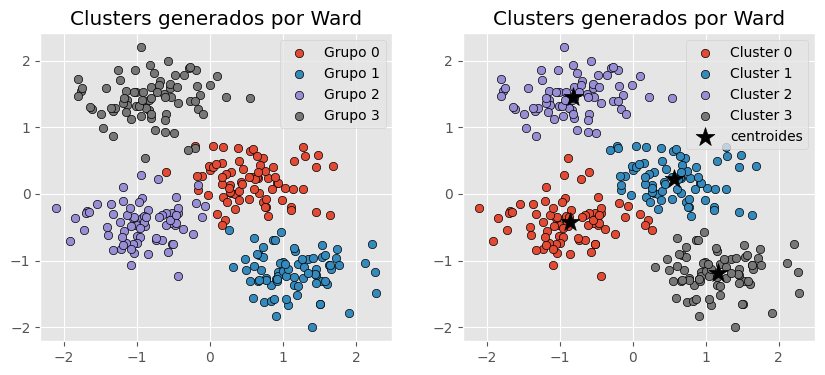

In [17]:
# Representación gráfica: grupos originales vs clusters creados
# ==============================================================================
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Grupos originales
for i in np.unique(y):
    ax[0].scatter(
        x = X_scaled[y == i, 0],
        y = X_scaled[y == i, 1], 
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black', 
        label= f"Grupo {i}"
    )
    
ax[0].set_title('Clusters generados por Ward')
ax[0].legend();

for i in np.unique(cluster_labels):
    ax[1].scatter(
        x = X_scaled[cluster_labels == i, 0],
        y = X_scaled[cluster_labels == i, 1], 
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black', 
        label= f"Cluster {i}"
    )
    
ax[1].scatter(
    x = clf.centroids_[:, 0],
    y = clf.centroids_[:, 1], 
    c = 'black',
    s = 200,
    marker = '*',
    label  = 'centroides'
)
ax[1].set_title('Clusters generados por Ward')
ax[1].legend();


In [18]:
plt.show()



**Matriz de confusión** con la verdad verdadera. 



In [19]:
# Matriz de confusión: grupos originales vs clusters creados
# ==============================================================================
pd.crosstab(y, cluster_labels, dropna=False, rownames=['grupo_real'], colnames=['cluster'])


cluster      0   1   2   3
grupo_real                
0            4  71   0   0
1            1   0   0  74
2           74   1   0   0
3            1   2  72   0

## Clustering K-means



In [20]:
# Modelo
# ==============================================================================
#X_scaled = scale(X)
modelo_kmeans = KMeans(n_clusters=4, n_init=25, random_state=123)
modelo_kmeans.fit(X=X_scaled)
print('Varianza intra: ' + str(modelo_kmeans.inertia_))

print('Centroides')
print(modelo_kmeans.cluster_centers_)

print('Etiquetas')
modelo_kmeans.labels_[:5]


Varianza intra: 88.2607592272184
Centroides
[[ 0.49467596  0.20121533]
 [-0.83858767  1.44733557]
 [ 1.17700129 -1.1610387 ]
 [-0.95344254 -0.44536732]]
Etiquetas


array([0, 1, 0, 1, 2])

In [21]:
# Clasificación con el modelo kmeans
# ==============================================================================
y_predict = modelo_kmeans.predict(X=X_scaled)

silhouette_score(X_scaled, y_predict)


0.554907869883264

In [22]:
from sklearn import metrics
metrics.calinski_harabasz_score(X_scaled, y_predict)


572.0730881047105

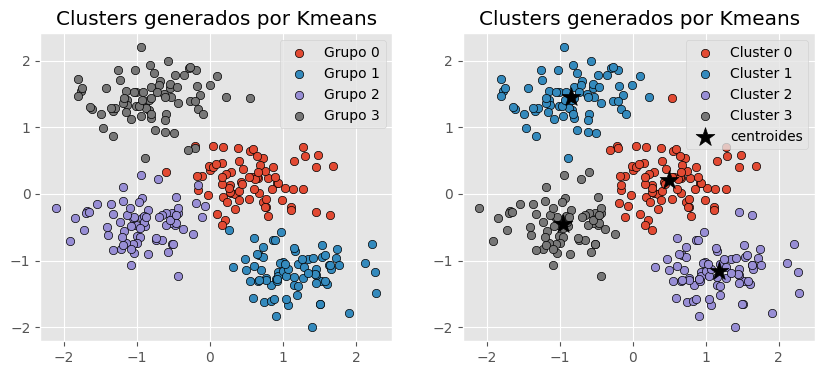

In [23]:
# Representación gráfica: grupos originales vs clusters creados
# ==============================================================================
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Grupos originales
for i in np.unique(y):
    ax[0].scatter(
        x = X_scaled[y == i, 0],
        y = X_scaled[y == i, 1], 
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black', 
        label= f"Grupo {i}"
    )
    
ax[0].set_title('Clusters generados por Kmeans')
ax[0].legend();

for i in np.unique(y_predict):
    ax[1].scatter(
        x = X_scaled[y_predict == i, 0],
        y = X_scaled[y_predict == i, 1], 
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black', 
        label= f"Cluster {i}"
    )
    
ax[1].scatter(
    x = modelo_kmeans.cluster_centers_[:, 0],
    y = modelo_kmeans.cluster_centers_[:, 1], 
    c = 'black',
    s = 200,
    marker = '*',
    label  = 'centroides'
)
ax[1].set_title('Clusters generados por Kmeans')
ax[1].legend();


In [24]:
plt.show()



In [25]:
# Matriz de confusión: grupos originales vs clusters creados
# ==============================================================================
pd.crosstab(y, y_predict, dropna=False, rownames=['grupo_real'], colnames=['cluster'])


cluster      0   1   2   3
grupo_real                
0           72   0   2   1
1            1   0  74   0
2            4   0   0  71
3            3  72   0   0

## Evaluación del número de grupos óptimo en K-means

Vamos a generar una función para facilitar la búsqueda del número de grupos óptimo en relación a 3 métricas. Variabilidad interna de los grupos, silueta y % de variabilidad explicada por los grupos con respecto a la variabilidad total del dataset. 

Con un input consistente en el dataset en bruto de aplicación (se escalará por si acaso dentro de la función) y el numero máximo de grupos a evaluar, proporciona una salida de 3 gráficos para la evolución de las 3 métricas a lo largo del número de clusters de la solución. 

Lo que buscamos es el famoso "codo" en los gráficos, es decir, a partir de qué punto las métricas se estabilizan un poco. Hay que resaultar que la función se programa para empezar en 2 grupos debido a que la silueta no está definida para 1 ó n grupos siendo n el número de registros (recordemos que necesita comparar con el cluster más cercano al de clasificación actual).


In [26]:
# Cremos función scree_plot_kmeans para buscar el número de clusters óptimo 
# con 3 métricas usuales. Wss, silueta y % de varianza explicada
# Input: data = dataset en bruto (se escala dentro de la propia función)
#        n_max = número máximo de grupos a evaluar
# ==============================================================================
from scipy.spatial.distance import cdist, pdist

def scree_plot_kmeans(data,n_max):
  range_n_clusters = range(2, n_max)
  X_scaled = scale(data)
  inertias = []
  silhouette = []
  var_perc = []
  
  for n_clusters in range_n_clusters:
      modelo_kmeans = KMeans(
                          n_clusters   = n_clusters, 
                          n_init       = 20, 
                          random_state = 123
                      )
      modelo_kmeans.fit(X_scaled)
      cluster_labels = modelo_kmeans.fit_predict(X_scaled)
      inertias.append(modelo_kmeans.inertia_)
      silhouette.append(silhouette_score(X_scaled, cluster_labels))
      tss = sum(pdist(X_scaled)**2)/X_scaled.shape[0]
      bss = tss - modelo_kmeans.inertia_
      var_perc.append(bss/tss*100)
      
  fig, ax = plt.subplots(1, 3, figsize=(16, 6))
  ax[0].plot(range_n_clusters, inertias, marker='o')
  ax[0].set_title("Scree plot Varianza intra")
  ax[0].set_xlabel('Número clusters')
  ax[0].set_ylabel('Intra-cluster (inertia)')
  
  ax[1].plot(range_n_clusters, silhouette, marker='o')
  ax[1].set_title("Scree plot silhouette")
  ax[1].set_xlabel('Número clusters')
  ax[1].set_ylabel('Media índices silhouette');
  
  ax[2].plot(range_n_clusters, var_perc, marker='o')
  ax[2].set_title("Scree plot % Varianza")
  ax[2].set_xlabel('Número clusters')
  ax[2].set_ylabel('% de varianza explicada')


Aplicamos la función a la matriz de puntos simulados en bruto **X**. 



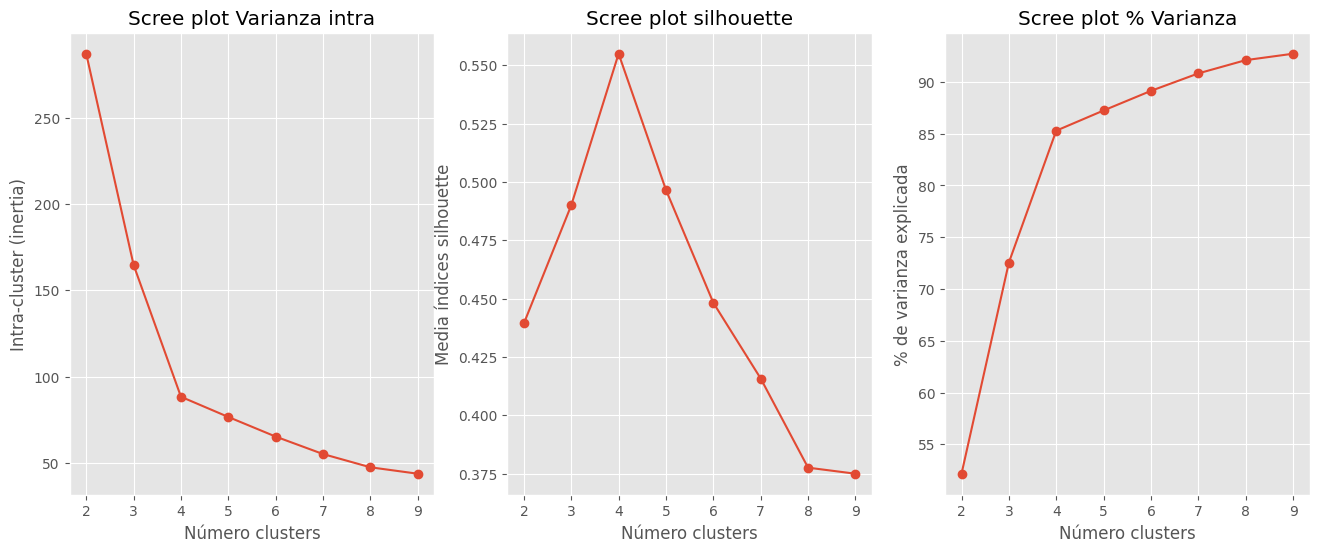

In [27]:
scree_plot_kmeans(X,10)
plt.show()


Los tres criterios son claros, aquí hay 4 grupos! Con un 90% de la variabilidad explicada tenemos la solución kmeans con 4 grupos. 


# Ejemplo Países 

Los datos paises.csv, contienen información sobre 3 indicadores (Death_Rate, BIrth_Rate, Infant_Death_Rate) en 97 países. 

El objetivo es conseguir grupos de países con la mayor homogeneidad interna.


In [28]:
# Lectura de datos
paises = pd.read_csv('C:\\Users\\Guille\\Documents\\Material Minería de Datos 2023_2024\\Datos\\paises.csv')

# Fijamos nombres como index de filas
#paises.set_index(['City'],inplace=True)
paises.head()


Unnamed: 0  Death_Rate  BIrth_Rate  Infant_Death_Rate
0  Albania                     24.7         5.7               30.8
1  Czechoslovakia              13.4        11.7               11.3
2  Hungary                     11.6        13.4               14.8
3  Romania                     13.6        10.7               26.9
4  USSR                        17.7        10.0               23.0

In [29]:
#import pyreadr

#paises = pyreadr.read_r('C:\\Users\\Guille\\Documents\\MineriaDatos_2022_23\\Datos\\paises.Rds') # also works for Rds
#paises.keys()


In [30]:
paises.set_index(['Unnamed: 0'],inplace=True)
paises.head()


Death_Rate  BIrth_Rate  Infant_Death_Rate
Unnamed: 0                                                     
Albania                     24.7         5.7               30.8
Czechoslovakia              13.4        11.7               11.3
Hungary                     11.6        13.4               14.8
Romania                     13.6        10.7               26.9
USSR                        17.7        10.0               23.0

**Escalado de datos**

En este caso, si fueran tasas medidas en la misma escala, no sería estrictamente necesario el escalado de los datos. Las soluciones deberían conservarse en ambas variantes. 

Sin embargo parece que la escala no es la que podríamos esperar y la tercera variable presenta valores más altos en general, escalamos. 


In [31]:
# Escalado de datos
# ==============================================================================
X_scaled = scale(paises)


## Clustering jerárquico

Probamos los métodos jerárquicos y observamos dendogramas para valorar separabilidad y número de grupos tentativos. 


ward :	0.00s


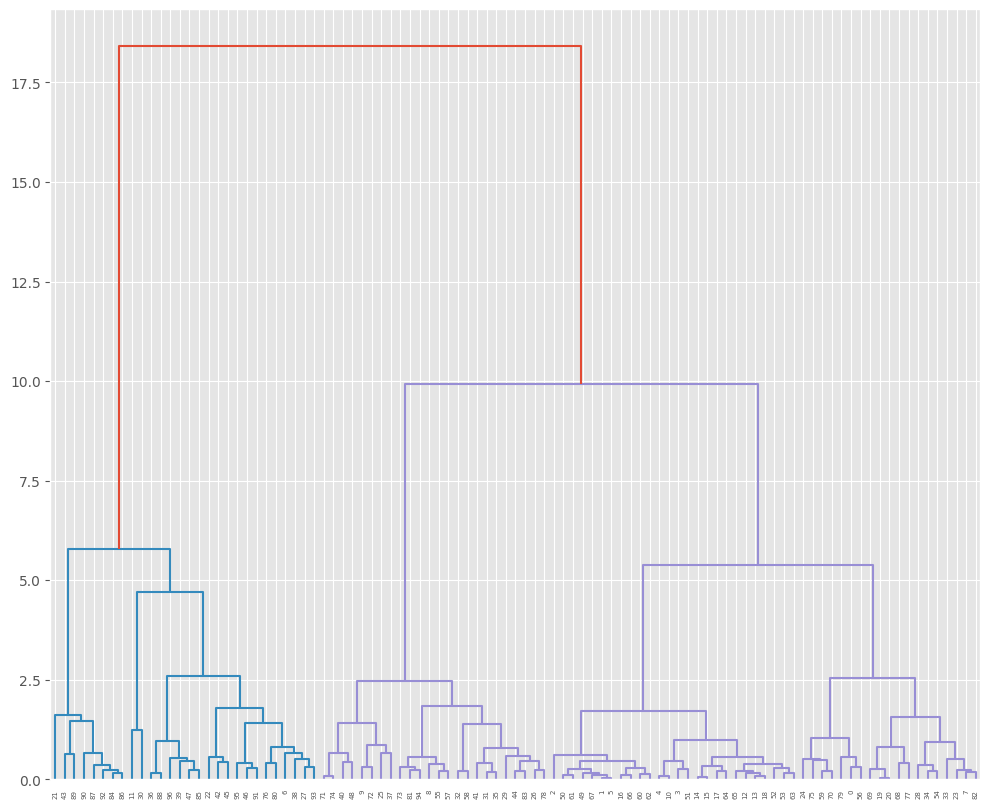

average :	0.00s


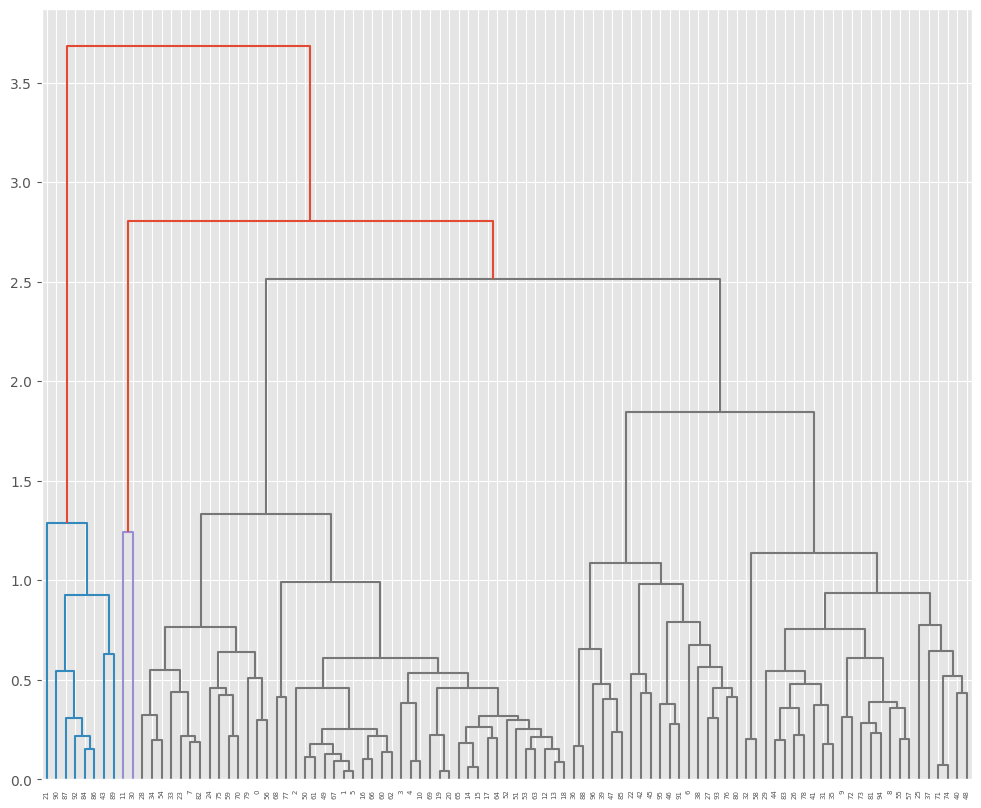

complete :	0.00s


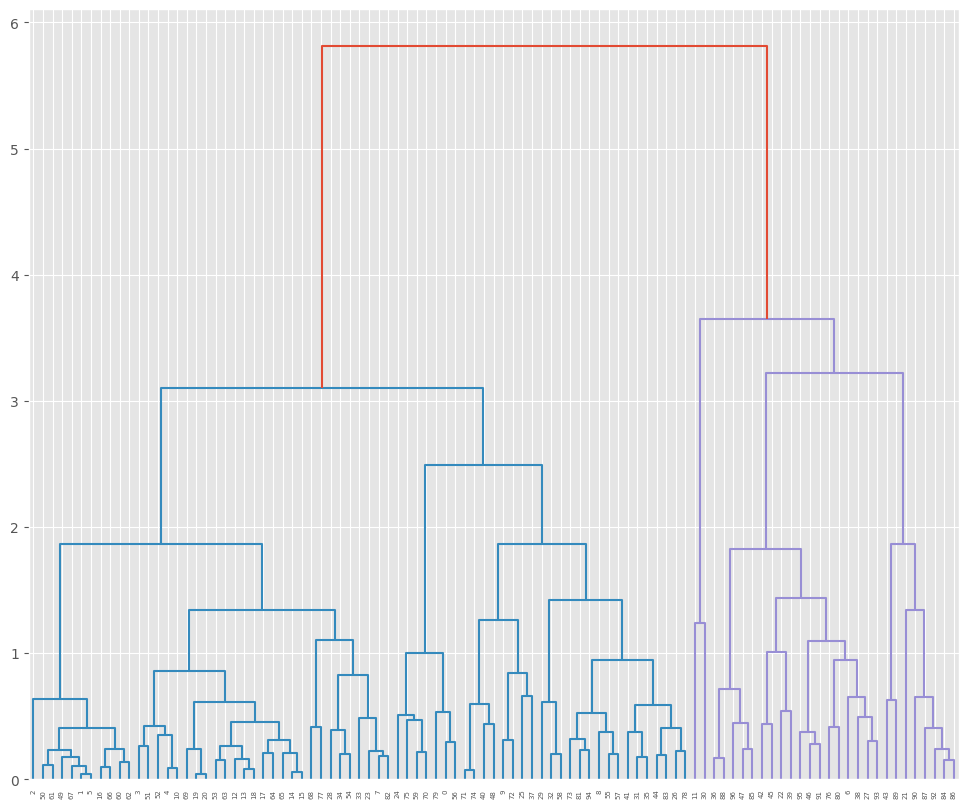

single :	0.00s


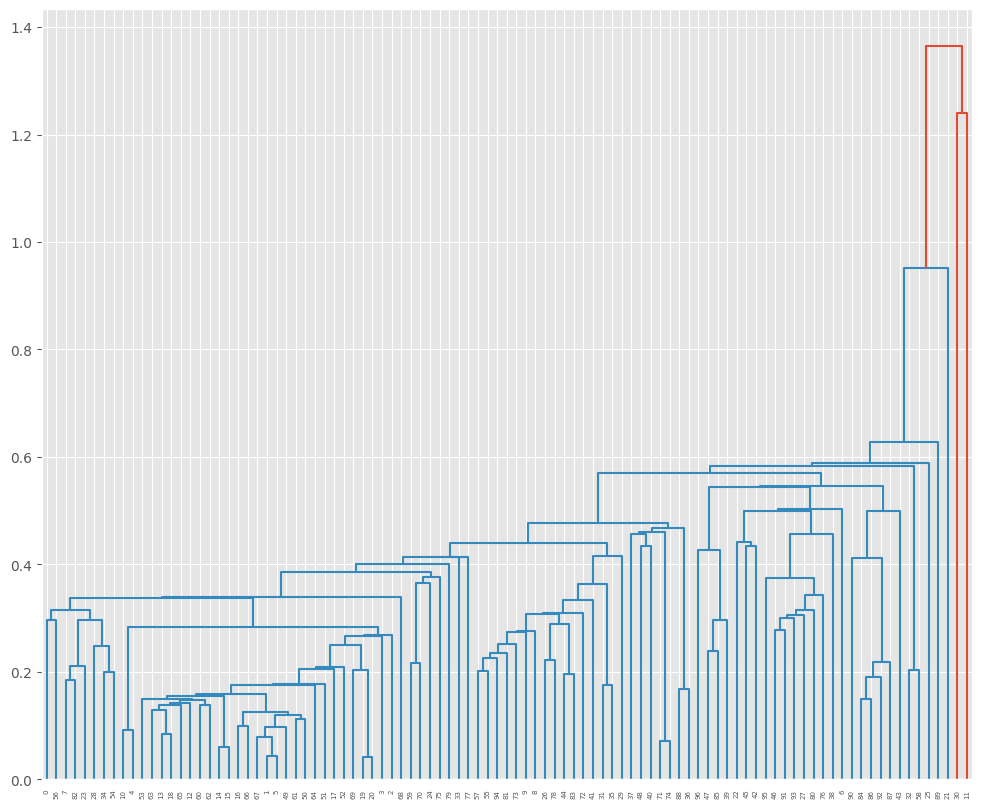

In [32]:
for linkage in ("ward", "average", "complete", "single"):
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=None,
                            distance_threshold = 0)
    t0 = time()
    clustering.fit(X_scaled)
    print("%s :\t%.2fs" % (linkage, time() - t0))
    
    plt.clf()
    plot_dendogram(clustering)
    #plot_clustering(X_scaled, clustering.labels_, "%s linkage" % linkage)


#plt.show()


Escogemos el método de mínima varianza que da resultados bastante claros para 3 grupos con alturas de corte muy definidas. 



In [33]:
modelo_hclust_ward = AgglomerativeClustering(
                            metric = 'euclidean',
                            linkage  = 'ward',
                            n_clusters  = 3
                     )
modelo_hclust_ward.fit(X=X_scaled)

cluster_labels = modelo_hclust_ward.fit_predict(X_scaled)


**Silueta clustering Ward**



In [34]:
silhouette_score(X_scaled, cluster_labels)



0.46577406014482053

**Indice de Calinski-Harabasz clustering Ward**



In [35]:
from sklearn import metrics
metrics.calinski_harabasz_score(X_scaled, cluster_labels)


142.5382693364912

## Visualización de resultados

Nos interesa ver la agrupación propuesta por el algoritmo de clustering en el espacio original de las variables. De esta forma, se pueden intuir los patrones de agrupación en base a las variables originales. 

En caso de tener muchas variables, se puede recurrir a un PCA previo para la visualización de los resultados, es algo muy habitual y frecuentemente implementado en los métodos de visualización del software (véase fviz de R). En python, hasta el punto que conozco no existe tal funcionalidad automática y tendremos que realizar el proceso de forma "manual" sencillamente haciendo el fit del modelo a los scores de un PCA con por ejemplo dos dimensiones para su mejor visualización. 


**Proyección sobre dos variables**


In [36]:
import plotly.express as px
paises['cluster'] = cluster_labels
fig = px.scatter(paises, x='Death_Rate',y='BIrth_Rate', color='cluster', text=paises.index)
fig.show()


**Otra proyección**



In [37]:
fig = px.scatter(paises, x='Death_Rate',y='Infant_Death_Rate', color='cluster', text=paises.index)
fig.show()


**Gráfico en 3 dimensiones** 



In [38]:
import plotly.express as px
paises['cluster'] = cluster_labels
fig = px.scatter_3d(paises, x='Death_Rate',y='BIrth_Rate', z='Infant_Death_Rate', color='cluster', text=paises.index)
fig.show()


**Cálculo de centroides para la interpretación**

Es importante en clustering caracterizar los grupos formados en base a sus centroides. Así, se definen características centrales de los grupos sobre las variables originales pudiendo determinar las diferencias y similitudes entre ellos. 

La idea final es obtener una interpretación de los grupos en base a valores medios en las variables del estudio. 


In [39]:
clf = NearestCentroid()
clf.fit(paises, cluster_labels)
pd.DataFrame(clf.centroids_,columns=paises.columns.tolist())
#[paises.columns.tolist(),'Grupo']

Death_Rate  BIrth_Rate  Infant_Death_Rate  cluster
0   44.596429   16.667857         109.382143      0.0
1   16.662222    8.488889          14.504444      1.0
2   34.866667    8.433333          67.083333      2.0

## Cluster K-means

Exploramos ahora la agrupación que propone el algoritmo K-means para el conjunto de datos de paises. 

En primer lugar, vamos a aplicar la función que hemos definido para graficar los screeplots en relación a las 3 métricas comentadas para valorar el número de grupos óptimo y comparar con los propuestos en el dendograma de ward. 


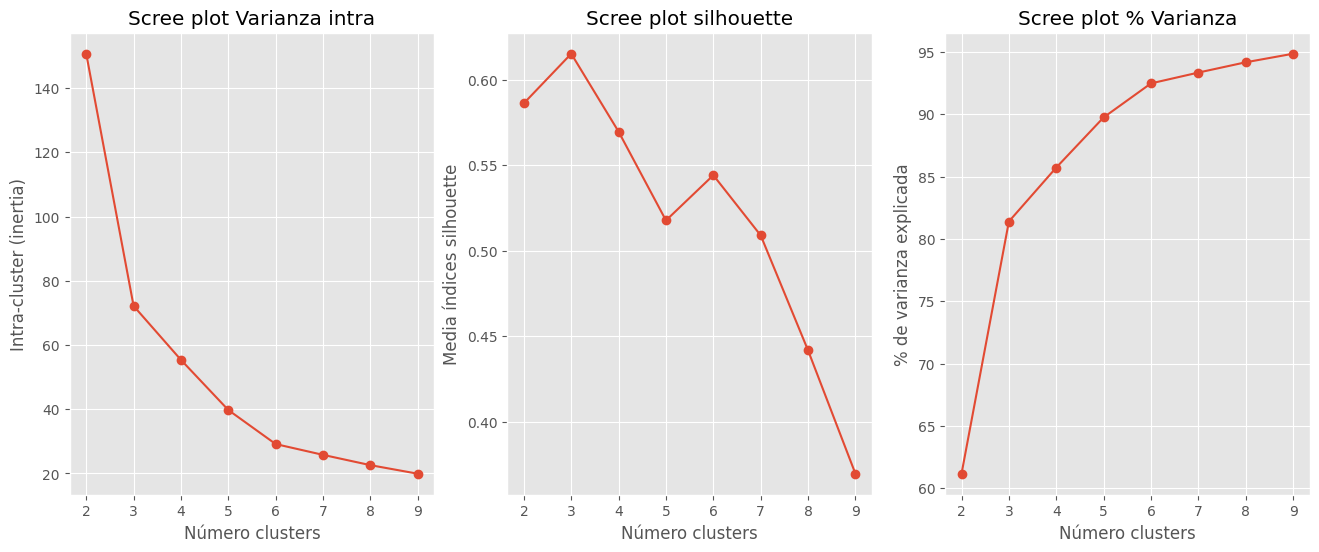

In [40]:
scree_plot_kmeans(paises,10)
plt.show()


De nuevo, parece que 3 grupos es lo ideal pero nos quedamos con algo menos del 80% de la variabilidad explicada. 

Ajustamos el clustering Kmeans con 3 grupos para extraer resultados y conclusiones.


In [41]:
modelo_kmeans = KMeans(n_clusters=3, n_init=25, random_state=123)
modelo_kmeans.fit(X=X_scaled)


KMeans(n_clusters=3, n_init=25, random_state=123)

In [42]:
print('Varianza intra: ' + str(modelo_kmeans.inertia_))



Varianza intra: 67.5799759949752


In [43]:
print('Centroides')
print(modelo_kmeans.cluster_centers_)


Centroides
[[ 1.1924373   1.3890524   1.341364  ]
 [-0.96431764 -0.43448038 -0.89505841]
 [ 0.47625796 -0.49034899  0.24792531]]


In [44]:
print('Etiquetas')
modelo_kmeans.labels_[:5]


Etiquetas


array([1, 1, 1, 1, 1])

### Métricas de evaluación



In [45]:
cluster_labels = modelo_kmeans.labels_
silhouette_score(X_scaled, cluster_labels)


0.48772140077136306

In [46]:
from sklearn import metrics
metrics.calinski_harabasz_score(X_scaled, cluster_labels)


155.38243353352073

### Visualización de resultados


**Proyección sobre dos variables**


In [47]:
import plotly.express as px
paises['cluster_kmeans'] = cluster_labels
fig = px.scatter(paises, x='Death_Rate',y='BIrth_Rate', color='cluster_kmeans', text=paises.index)
fig.show()


**Otra proyección**



In [48]:
fig = px.scatter(paises, x='Death_Rate',y='Infant_Death_Rate', color='cluster_kmeans', text=paises.index)
fig.show()


**Visualización en 3D**



In [49]:
fig = px.scatter_3d(paises, x='Death_Rate',y='BIrth_Rate', z='Infant_Death_Rate', color='cluster_kmeans', text=paises.index)
fig.show()


## Comparativa Ward-Kmeans

Vamos a ver el detalle de las observaciones que has sido clasificadas en distintos grupos por los dos métodos utilizados. 


In [50]:
paises[paises.cluster != paises.cluster_kmeans]



Death_Rate  BIrth_Rate  Infant_Death_Rate  cluster  \
Unnamed: 0                                                                 
Iran                        42.5        11.5              108.1        0   
Korea                       23.5        18.1               25.0        0   
Botswana                    48.5        11.6               67.0        0   
Columbia                    27.4         6.1               40.0        1   
Malaysia                    31.6         5.6               24.0        1   
Kenya                       47.0        11.3               72.0        0   

                      cluster_kmeans  
Unnamed: 0                            
Iran                               2  
Korea                              1  
Botswana                           2  
Columbia                           2  
Malaysia                           2  
Kenya                              2

In [51]:
# Establecer correspondencias
pd.crosstab(paises.cluster,paises.cluster_kmeans)



cluster_kmeans   0   1   2
cluster                   
0               24   1   3
1                0  43   2
2                0   0  24

In [52]:
paises[(paises.cluster == 0) & (paises.cluster_kmeans != 0)]



Death_Rate  BIrth_Rate  Infant_Death_Rate  cluster  \
Unnamed: 0                                                                 
Iran                        42.5        11.5              108.1        0   
Korea                       23.5        18.1               25.0        0   
Botswana                    48.5        11.6               67.0        0   
Kenya                       47.0        11.3               72.0        0   

                      cluster_kmeans  
Unnamed: 0                            
Iran                               2  
Korea                              1  
Botswana                           2  
Kenya                              2

In [53]:
paises[(paises.cluster == 1) & (paises.cluster_kmeans != 0)]



Death_Rate  BIrth_Rate  Infant_Death_Rate  cluster  \
Unnamed: 0                                                                 
Albania                     24.7         5.7               30.8        1   
Czechoslovakia              13.4        11.7               11.3        1   
Hungary                     11.6        13.4               14.8        1   
Romania                     13.6        10.7               26.9        1   
USSR                        17.7        10.0               23.0        1   
Ukrainian_SSR               13.4        11.6               13.0        1   
Chile                       23.4         5.8               17.1        1   
Uruguay                     18.0         9.6               21.9        1   
Finland                     13.2        10.1                5.8        1   
France                      13.6         9.4                7.4        1   
Greece                      10.1         9.2               11.0        1   
Italy                        9.7         9.1                8.8        1   
Norway                      14.3        10.7                7.8        1   
Spain                       10.7         8.2                8.1        1   
Switzerland                 12.5         9.5                7.1        1   
Austria                     14.9         7.4                8.0        1   
Canada                      14.5         7.3                7.2        1   
Israel                      22.3         6.3                9.7        1   
Kuwait                      26.8         2.2               15.6        1   
China                       21.2         6.7               32.0        1   
Singapore                   17.8         5.2                7.5        1   
Thailand                    22.3         7.7               28.0        1   
Bulgaria                    12.5        11.9               14.4        1   
Former_E._Germany           12.0        12.4                7.6        1   
Poland                      14.3        10.2               16.0        1   
Yugoslavia                  14.0         9.0               20.2        1   
Byelorussia_SSR             15.2         9.5               13.1        1   
Argentina                   20.7         8.4               25.7        1   
Columbia                    27.4         6.1               40.0        1   
Venezuela                   27.5         4.4               23.3        1   
Belgium                     12.0        10.6                7.9        1   
Denmark                     12.4        11.9                7.5        1   
Germany                     11.4        11.2                7.4        1   
Ireland                     15.1         9.1                7.5        1   
Netherlands                 13.2         8.6                7.1        1   
Portugal                    11.9         9.5               13.1        1   
Sweden                      14.5        11.1                5.6        1   
U.K.                        13.6        11.5                8.4        1   
Japan                        9.9         6.7                4.5        1   
U.S.A.                      16.7         8.1                9.1        1   
Bahrain                     28.4         3.8               16.0        1   
United_Arab_Emirates        22.8         3.8               26.0        1   
Hong_Kong                   11.7         4.9                6.1        1   
Malaysia                    31.6         5.6               24.0        1   
Sri_Lanka                   21.3         6.2               19.4        1   

                      cluster_kmeans  
Unnamed: 0                            
Albania                            1  
Czechoslovakia                     1  
Hungary                            1  
Romania                            1  
USSR                               1  
Ukrainian_SSR                      1  
Chile                              1  
Uruguay                            1  
Finland                            1  
France              

# Datos actuales del Banco mundial 

Pasamos ahora a extraer los datos más actuales desde el banco mundial. En este caso los tenemos en excel ya que los decargué y limpié un poco pero siempre se puede recurrir al scrapping de esta buena fuente de datos!! Para mas información consultar la página del paquete:

https://wbdata.readthedocs.io/en/stable/

Descripción de funciones y parámetros aquí: 

https://wbdata.readthedocs.io/en/stable/wbdata_library.html

## Scrapping rápido 

Con el paquete **wbdata** vamos a coger lo que queremos del Banco Mundial. Hay todo tipo de información, indicadores de lo que se pueda llegar a imaginar por paises a nivel anual e incluso otros como mensual. 

Podemos cargar la librería e investigar un poco. En primer lugar vemos las distintas fuentes de datos disponibles. 

**Nota**: Aquí nos han cambiado algunas funciones del paquete en nueva versión! Son cambios menores con respecto a la versión anterior y aparecen aquí: https://wbdata.readthedocs.io/en/stable/whats_new/


In [81]:
#pip install -U wbdata
import wbdata  

#wbdata.get_sources() 
wbdata.get_topics()

  id  value
----  -------------------------------
   1  Agriculture & Rural Development
   2  Aid Effectiveness
   3  Economy & Growth
   4  Education
   5  Energy & Mining
   6  Environment
   7  Financial Sector
   8  Health
   9  Infrastructure
  10  Social Protection & Labor
  11  Poverty
  12  Private Sector
  13  Public Sector
  14  Science & Technology
  15  Social Development
  16  Urban Development
  17  Gender
  18  Millenium development goals
  19  Climate Change
  20  External Debt
  21  Trade

Podemos consultar la lista de paises disponibles. Cuidado! Aquí son países + agregaciones varias que hay disponibles. Esta parte no está muy conseguida en la descarga y habrá que aplicar el walkaround recomendado por el autor. 



In [55]:
#wbdata.get_indicators(source=2)
#wbdata.get_countries()
#wbdata.get_lendingtype()


**Descarga de datos**. Vamos a descargar un dataframe al estilo pandas que contenga la información que queremos. Estos 3 indicadores por ejemplo para el 2020 y para todos los países (excluyendo agregaciones). Como la fecha tiene que ser datetime, importamos la librería para generar la fecha (podría ser una fecha inicio y fecha fin). Los idicadores pues nos los sabemos pero siempre podemos indagar con searh_indicator() para quedarnos con el id adecuado. 



In [56]:
wbdata.get_indicators(query="death rate") 



id              name
--------------  --------------------------------------------
SH.TBS.MORT     Tuberculosis death rate (per 100,000 people)
SP.DYN.CDRT.IN  Death rate, crude (per 1,000 people)

Tarda un poco pero ahí está, es el id *SP.DYN.CDRT.IN*



In [57]:
wbdata.get_indicators(query="birth rate") 



id              name
--------------  ------------------------------------------
SH.DYN.STLB     Stillbirth rate (per 1,000 total births)
SP.BRT.CRUD.ZT  Crude Birth Rate (per 1000 population)
SP.DYN.CBRT     Crude Birth Rate (per thousand population)
SP.DYN.CBRT.IN  Birth rate, crude (per 1,000 people)

In [58]:
wbdata.get_indicators(query="mortality", topic=8) 



id                 name
-----------------  --------------------------------------------------------------------------------------------------------------------------
SH.DYN.CHLD.FE     Mortality rate, female child (per 1,000 female children age one)
SH.DYN.CHLD.MA     Mortality rate, male child (per 1,000 male children age one)
SH.DYN.MORT        Mortality rate, under-5 (per 1,000 live births)
SH.DYN.MORT.FE     Mortality rate, under-5, female (per 1,000 live births)
SH.DYN.MORT.MA     Mortality rate, under-5, male (per 1,000 live births)
SH.DYN.MORT.Q1     Under-5 mortality rate (per 1,000 live births): Q1 (lowest)
SH.DYN.MORT.Q2     Under-5 mortality rate (per 1,000 live births): Q2
SH.DYN.MORT.Q3     Under-5 mortality rate (per 1,000 live births): Q3
SH.DYN.MORT.Q4     Under-5 mortality rate (per 1,000 live births): Q4
SH.DYN.MORT.Q5     Under-5 mortality rate (per 1,000 live births): Q5 (highest)
SH.DYN.NCOM.FE.ZS  Mortality from CVD, cancer, diabetes or CRD between exact ages 30 a

In [59]:
wbdata.get_countries()

id    name
----  --------------------------------------------------------------------------------
ABW   Aruba
AFE   Africa Eastern and Southern
AFG   Afghanistan
AFR   Africa
AFW   Africa Western and Central
AGO   Angola
ALB   Albania
AND   Andorra
ARB   Arab World
ARE   United Arab Emirates
ARG   Argentina
ARM   Armenia
ASM   American Samoa
ATG   Antigua and Barbuda
AUS   Australia
AUT   Austria
AZE   Azerbaijan
BDI   Burundi
BEA   East Asia & Pacific (IBRD-only countries)
BEC   Europe & Central Asia (IBRD-only countries)
BEL   Belgium
BEN   Benin
BFA   Burkina Faso
BGD   Bangladesh
BGR   Bulgaria
BHI   IBRD countries classified as high income
BHR   Bahrain
BHS   Bahamas, The
BIH   Bosnia and Herzegovina
BLA   Latin America & the Caribbean (IBRD-only countries)
BLR   Belarus
BLZ   Belize
BMN   Middle East & North Africa (IBRD-only countries)
BMU   Bermuda
BOL   Bolivia
BRA   Brazil
BRB   Barbados
BRN   Brunei Darussalam
BSS   Sub-Saharan Africa (IBRD-only countries)
BTN   Bhutan
BWA  

In [60]:
import datetime
data_date = datetime.datetime(2020, 1, 1)  #, datetime.datetime(2011, 1, 1)                                                                                      
countries = [i['id'] for i in wbdata.get_countries() if not i['incomeLevel']['value'] == "Aggregates"]  
indicators = {"SP.DYN.CDRT.IN": "Death rate", "SP.DYN.CBRT.IN": "Birth rate", "SP.DYN.IMRT.IN": "Mortality rate_infant"}         

paises_BM = wbdata.get_dataframe(indicators, country=countries, date=data_date)  


In [61]:
paises=paises_BM
#wbdata.get_topic()

#wbdata.get_indicator(topic=4)
paises

Death rate  Birth rate  Mortality rate_infant
country                                                    
Aruba              9.690       8.102                    NaN
Afghanistan        7.113      36.051                   47.4
Angola             7.821      39.271                   48.4
Albania           10.785      10.285                    8.4
Andorra              NaN         NaN                    2.8
...                  ...         ...                    ...
Kosovo             7.505      11.181                    9.6
Yemen, Rep.        6.509      31.252                   34.5
South Africa       9.425      20.326                   28.1
Zambia             6.602      34.953                   40.9
Zimbabwe           8.132      31.009                   36.4

[217 rows x 3 columns]

In [62]:
# Lectura de datos
#paises2 = pd.read_excel('Paises_2020_BancoMundial.xlsx')

# Fijamos nombres como index de filas
#paises.set_index(['City'],inplace=True)
paises.shape


(217, 3)

Hay valores perdidos que estas técnicas no admiten. Haremos un borrado por lista. 



In [63]:
paises = paises.dropna()
paises


Death rate  Birth rate  Mortality rate_infant
country                                                            
Afghanistan                7.113      36.051                   47.4
Angola                     7.821      39.271                   48.4
Albania                   10.785      10.285                    8.4
United Arab Emirates       1.766      10.620                    4.8
Argentina                  8.509      14.125                    8.9
...                          ...         ...                    ...
Kosovo                     7.505      11.181                    9.6
Yemen, Rep.                6.509      31.252                   34.5
South Africa               9.425      20.326                   28.1
Zambia                     6.602      34.953                   40.9
Zimbabwe                   8.132      31.009                   36.4

[194 rows x 3 columns]

Valoramos el número de grupos seleccionando evidentemente solo las avriables de interés que son las numéricas. 



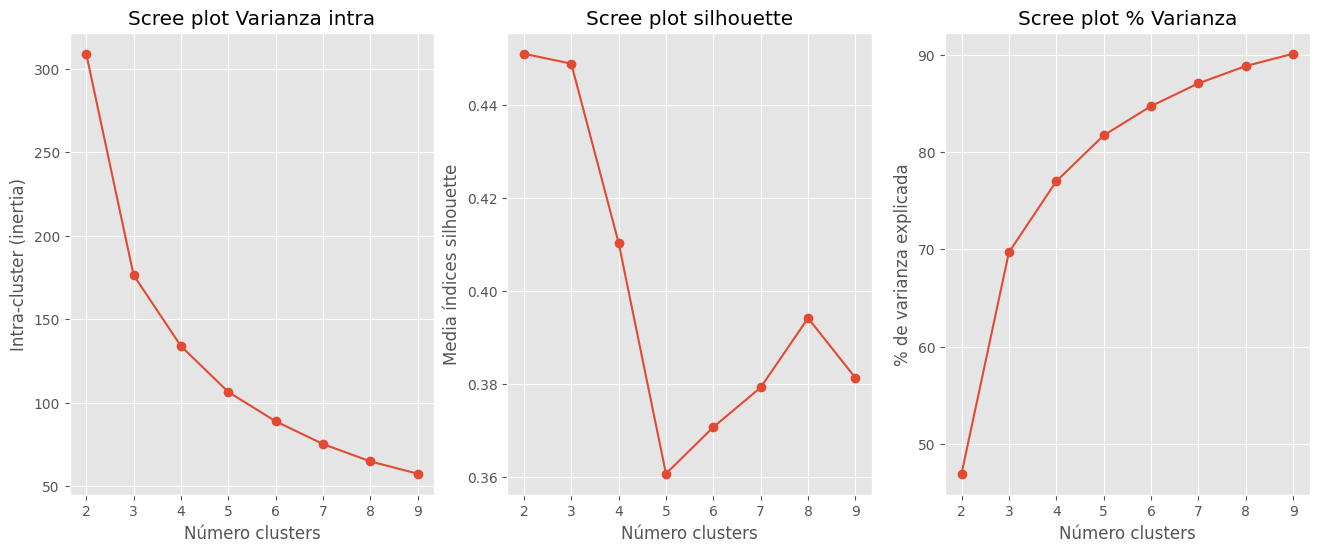

In [64]:
scree_plot_kmeans(paises.select_dtypes(np.number),10)
plt.show()


Ajustamos el clustering Kmeans con 3 grupos para extraer resultados y conclusiones.



In [65]:
X_scaled = scale(paises.select_dtypes(np.number))
modelo_kmeans = KMeans(n_clusters=3, n_init=25, random_state=123)
modelo_kmeans.fit(X=X_scaled)


KMeans(n_clusters=3, n_init=25, random_state=123)

In [66]:
print('Varianza intra: ' + str(modelo_kmeans.inertia_))



Varianza intra: 176.39549556962956


In [67]:
print('Centroides')
print(modelo_kmeans.cluster_centers_)


Centroides
[[-0.57572066 -0.28868684 -0.37982942]
 [-0.03041068  1.33081063  1.38697177]
 [ 1.39543123 -0.99888014 -0.85491409]]


In [68]:
print('Etiquetas')
modelo_kmeans.labels_[:5]


Etiquetas


array([1, 1, 2, 0, 0])

### Métricas de evaluación



In [69]:
cluster_labels = modelo_kmeans.labels_
silhouette_score(X_scaled, cluster_labels)


0.44887976836870397

In [70]:
from sklearn import metrics
metrics.calinski_harabasz_score(X_scaled, cluster_labels)


219.59308001609492

### Visualización de resultados


**Proyección sobre dos variables**


In [71]:
import plotly.express as px
paises['cluster_kmeans'] = cluster_labels
fig = px.scatter(paises, x='Death rate',y='Birth rate', color='cluster_kmeans', text=paises.index)
fig.show()


**Otra proyección**



In [72]:
fig = px.scatter(paises, x='Birth rate',y='Mortality rate_infant', color='cluster_kmeans', text=paises.index)
fig.show()


**Visualización en 3D**



In [73]:
fig = px.scatter_3d(paises, x='Death rate',y='Birth rate', z='Mortality rate_infant', color='cluster_kmeans', text=paises.index)
fig.show()


**Proyección sobre componentes principales. Biplot**

Ilustramos en esta última parte el proceso para pintar el biplot de la solución de clustering distinguiendo los registros por clusters en el plano de las dos primeras componentes principales del archivo de variables. Este método es muy útil para la visualización de las soluciones especialemnte en alta dimensionalidad, cuando tenemos muchas variables en el archivo original, ya que nos evitamos tener que proyectar sobre muchos pares de variables. 

Para llevar a cabo esta tarea, debemos ajustar un PCA a la matriz de entrada de variables para el clustering. Importante que si hemos escalado los datos de cara al clustering, lo hagamos también para el PCA. Una vez se ajusta el PCA a los datos, necesitaremos la matriz de *scores* de la solución (registros vs. componentes) como nuevas variables que forman el plano de proyección. 

En esta ocasión vamos a recurrir a la librería **pca** y accederemos a la solución para la proyección posterior. 

In [74]:
from sklearn import decomposition as dc
#pcaModel =dc.PCA(n_components=2).fit(X_scaled)
# Load library
from pca import pca

# Initialize pca with default parameters
pcaModel = pca(normalize=True,n_components=2)
results = pcaModel.fit_transform(paises.iloc[:,:3])


[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >Normalizing input data per feature (zero mean and unit variance)..
[pca] >The PCA reduction is performed on the [3] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


(<Figure size 1500x1000 with 1 Axes>,
 <Axes: title={'center': 'Cumulative explained variance\n 2 Principal Components explain [96.30%] of the variance.'}, xlabel='Principal Component', ylabel='Percentage explained variance'>)

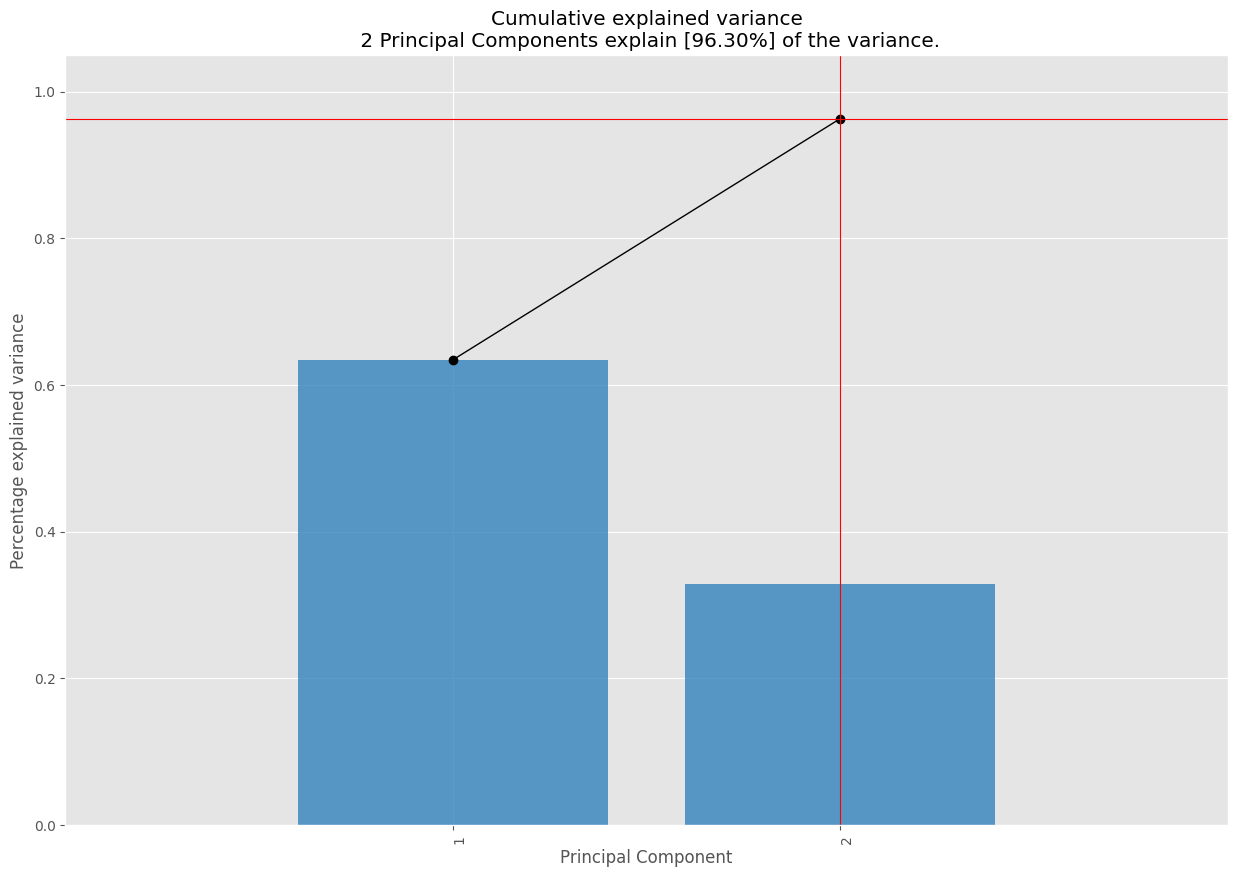

In [75]:
pcaModel.plot()

In [76]:
# Acceso a las cargas
pcaModel.results['loadings']

Death rate  Birth rate  Mortality rate_infant
PC1   -0.196937    0.704352               0.681985
PC2    0.967126    0.025421               0.253023

[scatterd] >INFO> Create scatterplot


[pca] >Plot PC1 vs PC2 with loadings.
[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.


(<Figure size 2500x1500 with 1 Axes>,
 <Axes: title={'center': '2 Principal Components explain [96.30%] of the variance'}, xlabel='PC1 (63.4% expl.var)', ylabel='PC2 (32.9% expl.var)'>)

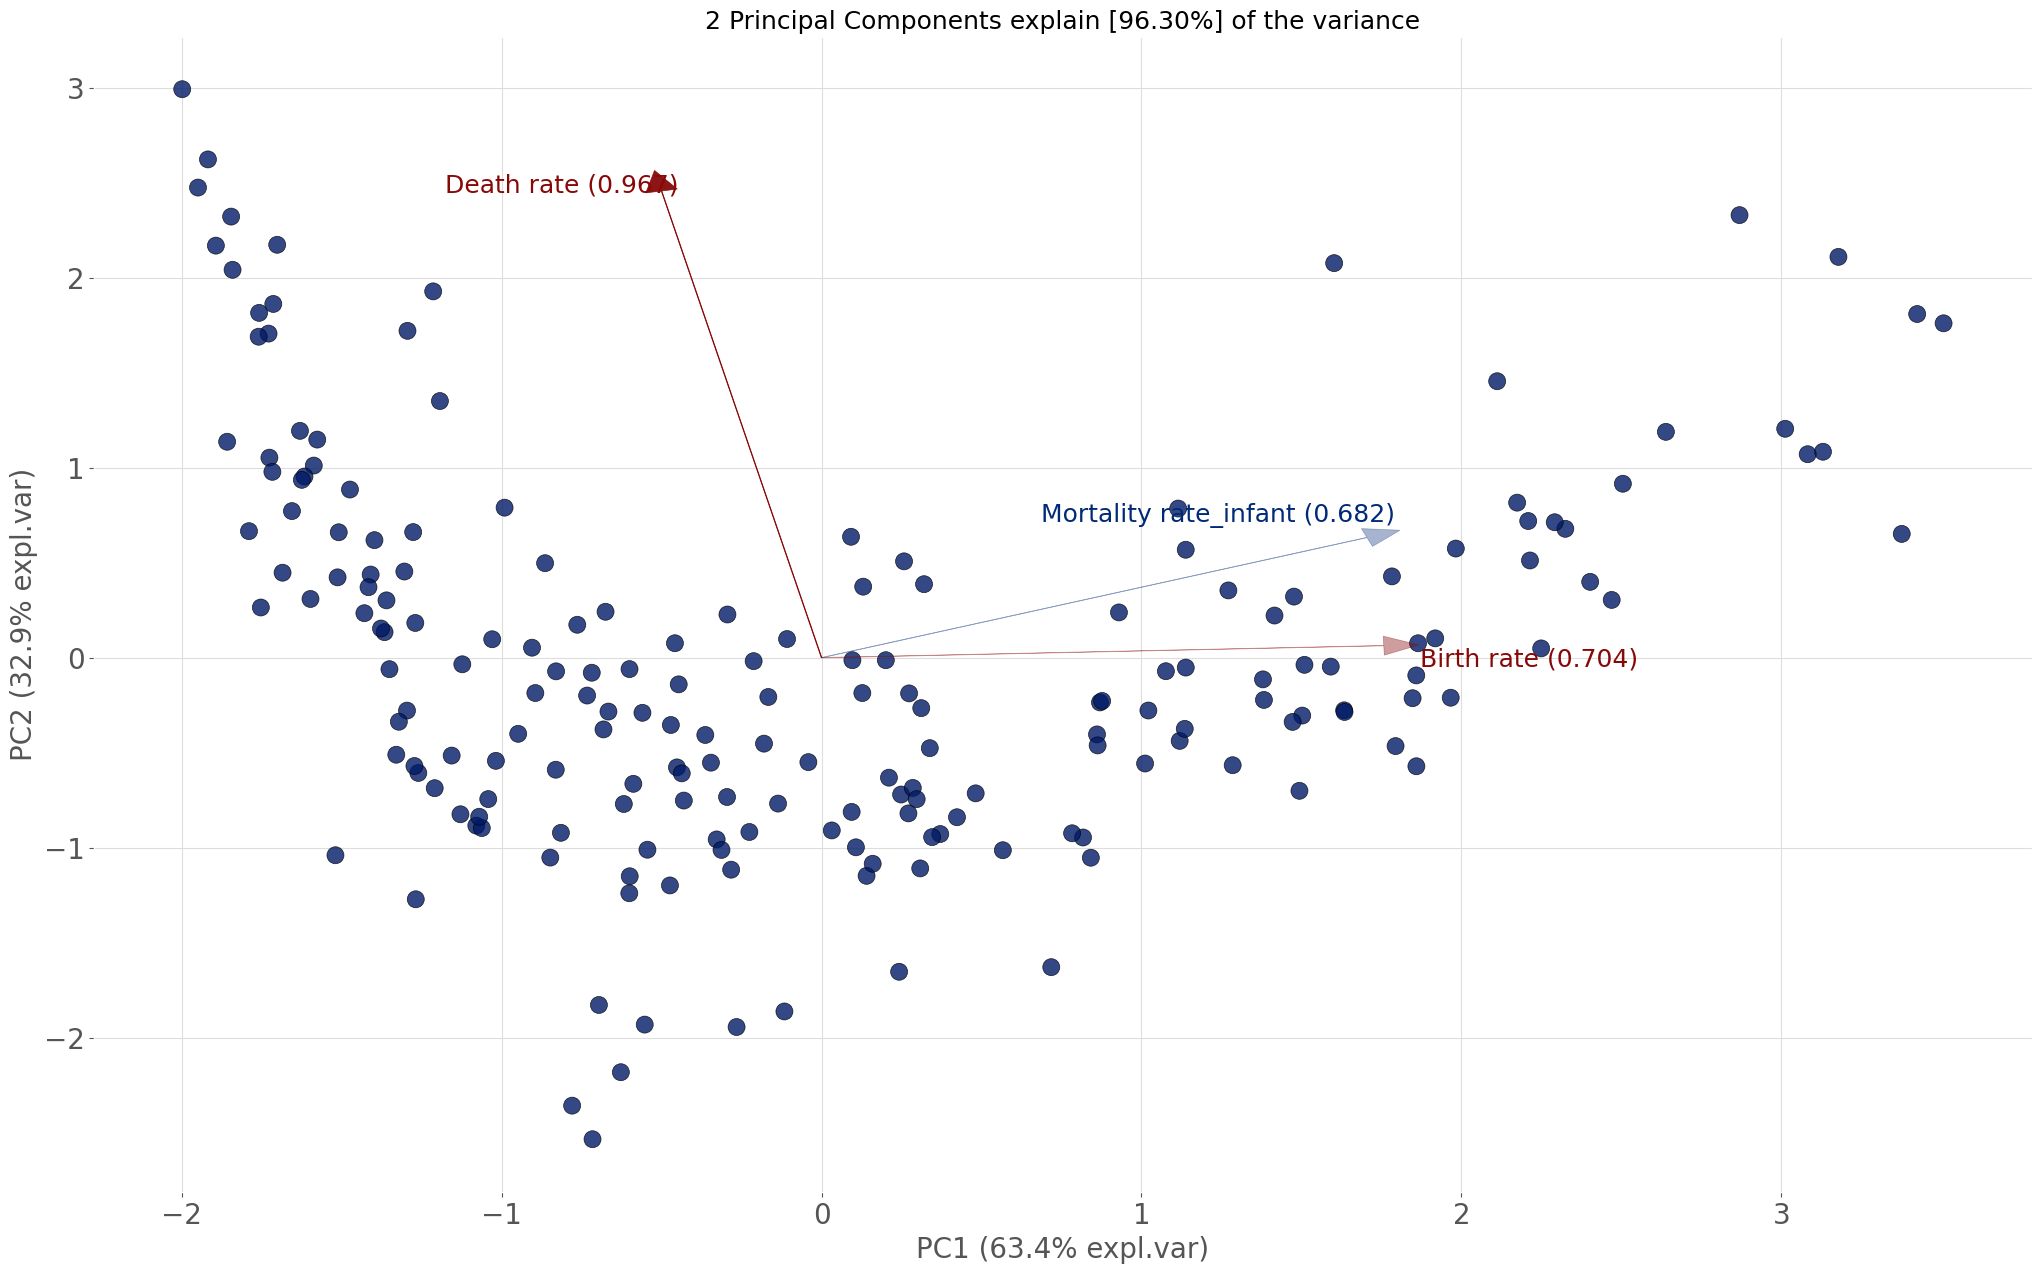

In [77]:
# Visualización biplot para interpretar componentes
pcaModel.biplot(legend=False)

Con dos componentes retenemos el 96,4% de la variabilidad del archivo. Se observa que la componente 1 está asociada en sentido positivo a tasa de nacimeintos y tasa de muerte infantil, mientras que la componente 2 se asocia a la tasa de muerte. Así, los países del primer cuadrante presentan, altas tasas de nacimiento y muerte infantil con alta tasa de muerte.En cambio, los países del tercer cuadrante, con valores negativos en ambas compoentes, se caracterizan por bajas tasas de nacimiento y muerte infantil unido a una baja tasa de muertes. 

Con esta información podremos evaluar las regiones donde se sitúan los clusters creados. 

In [78]:
# Acceso a scores
pcaModel.results['PC']

PC1       PC2
Afghanistan           2.249382  0.048999
Angola                2.469749  0.304082
Albania              -1.276473  0.660942
United Arab Emirates -0.779637 -2.357032
Argentina            -0.829833 -0.071774
...                        ...       ...
Kosovo               -0.948215 -0.400490
Yemen, Rep.           1.472419 -0.337785
South Africa          0.257826  0.507069
Zambia                1.966524 -0.210522
Zimbabwe              1.415798  0.221868

[194 rows x 2 columns]

In [79]:
# Unimos variable de cluster_kmeans previamente creada
paises_pca = pcaModel.results['PC'].join(paises['cluster_kmeans'])
paises_pca

PC1       PC2  cluster_kmeans
Afghanistan           2.249382  0.048999               1
Angola                2.469749  0.304082               1
Albania              -1.276473  0.660942               2
United Arab Emirates -0.779637 -2.357032               0
Argentina            -0.829833 -0.071774               0
...                        ...       ...             ...
Kosovo               -0.948215 -0.400490               0
Yemen, Rep.           1.472419 -0.337785               1
South Africa          0.257826  0.507069               0
Zambia                1.966524 -0.210522               1
Zimbabwe              1.415798  0.221868               1

[194 rows x 3 columns]

In [80]:
# Visualización del biplot por cluster
fig = px.scatter(paises_pca, x='PC1',y='PC2', color='cluster_kmeans', text=paises.index)
fig.show()

En amarillo los países que se sitúan en el cuadrante 2, con bajas tasas de nacimiento y muerte infantil pero altas tasas de muerte. En azul el mundo interemedio, con tasas bastante repartidas en torno al centro de coordenadas, con tasa de muerte más naja de los tres grupos. En Rojo, el mundo "subdesarrollado" con tasas de nacimiento y muerte infantil altas y tasa de muerte entre media y alta. 